# 불균형 데이터로 신용카드 사기탐지 모델 구현하기

### 사기탐지 분류모형 개요
#### 금융데이터의 특성(Review)
- 1) 이종(heterogeneous) 데이터의 결합
- 2) 분포의 편향성
- 3) 분류 레이블의 불명확성
- 4) 변수의 다중공선성
- 5) 변수의 비선형성
- 그 외 현실적인 규제, 수집, 저장 등의 한계 때문에 데이터가 불완전할 수 있음


### 불균형 데이터의 머신러닝
- 데이터 불균형 : 머신러닝의 지도학습에서 분류하기 위한 각 클래스(레이블)에 해당하는 데이터의 양에 차이가 큰 경우
- 특정 클래스가 부족할 때 생기는 문제: (1)과대적합, (2) 알고리즘이 수렴하지 않는 현상 발생
- 1) X(피처)의 불균형
  + 범주변수일 경우 범주에 따라 빈도가 낮을 수 있음
  + 고차원 피처 공간의 축소
  + PCA, t-SNE등의 알고리즘 사용
- 2) Y(타겟)의 불균형
  + 여신(대출), 수신(적금), 보험(클레임), 카드(사기탐지), 거시경제(불황) 등 대부분의 금융 데이터는 희소 타겟 문제
  + 리샘플링으로 저빈도 데이터를 극복
  + 무선 과대표집, 무선 과소표집, SMOTE, Tomek Links 등의 알고리즘 사용

In [2]:
# 데이터를 학습에 맞게 변환
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
%matplotlib inline


In [3]:
import warnings
warnings.filterwarnings("ignore")

In [14]:
# 데이터 확인하기

filepath = 'https://github.com/mchoimis/financialml/raw/main/fraud/'

In [15]:
# 파일 불러오기
df = pd.read_csv(filepath + 'fraud.csv')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 284807 entries, 0 to 284806
Data columns (total 31 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   Time    284807 non-null  float64
 1   V1      284807 non-null  float64
 2   V2      284807 non-null  float64
 3   V3      284807 non-null  float64
 4   V4      284807 non-null  float64
 5   V5      284807 non-null  float64
 6   V6      284807 non-null  float64
 7   V7      284807 non-null  float64
 8   V8      284807 non-null  float64
 9   V9      284807 non-null  float64
 10  V10     284807 non-null  float64
 11  V11     284807 non-null  float64
 12  V12     284807 non-null  float64
 13  V13     284807 non-null  float64
 14  V14     284807 non-null  float64
 15  V15     284807 non-null  float64
 16  V16     284807 non-null  float64
 17  V17     284807 non-null  float64
 18  V18     284807 non-null  float64
 19  V19     284807 non-null  float64
 20  V20     284807 non-null  float64
 21  V21     28

In [16]:
# 로드한 데이터의 맨 윗 30개 행 확인하기
df.head(30)

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,0.090794,-0.551600,-0.617801,-0.991390,-0.311169,1.468177,-0.470401,0.207971,0.025791,0.403993,0.251412,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,-0.166974,1.612727,1.065235,0.489095,-0.143772,0.635558,0.463917,-0.114805,-0.183361,-0.145783,-0.069083,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,0.207643,0.624501,0.066084,0.717293,-0.165946,2.345865,-2.890083,1.109969,-0.121359,-2.261857,0.524980,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,-0.054952,-0.226487,0.178228,0.507757,-0.287924,-0.631418,-1.059647,-0.684093,1.965775,-1.232622,-0.208038,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,0.753074,-0.822843,0.538196,1.345852,-1.119670,0.175121,-0.451449,-0.237033,-0.038195,0.803487,0.408542,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0
5,2.0,-0.425966,0.960523,1.141109,-0.168252,0.420987,-0.029728,0.476201,0.260314,-0.568671,-0.371407,1.341262,0.359894,-0.358091,-0.137134,0.517617,0.401726,-0.058133,0.068653,-0.033194,0.084968,-0.208254,-0.559825,-0.026398,-0.371427,-0.232794,0.105915,0.253844,0.081080,3.67,0
6,4.0,1.229658,0.141004,0.045371,1.202613,0.191881,0.272708,-0.005159,0.081213,0.464960,-0.099254,-1.416907,-0.153826,-0.751063,0.167372,0.050144,-0.443587,0.002821,-0.611987,-0.045575,-0.219633,-0.167716,-0.270710,-0.154104,-0.780055,0.750137,-0.257237,0.034507,0.005168,4.99,0
7,7.0,-0.644269,1.417964,1.074380,-0.492199,0.948934,0.428118,1.120631,-3.807864,0.615375,1.249376,-0.619468,0.291474,1.757964,-1.323865,0.686133,-0.076127,-1.222127,-0.358222,0.324505,-0.156742,1.943465,-1.015455,0.057504,-0.649709,-0.415267,-0.051634,-1.206921,-1.085339,40.80,0
8,7.0,-0.894286,0.286157,-0.113192,-0.271526,2.669599,3.721818,0.370145,0.851084,-0.392048,-0.410430,-0.705117,-0.110452,-0.286254,0.074355,-0.328783,-0.210077,-0.499768,0.118765,0.570328,0.052736,-0.073425,-0.268092,-0.204233,1.011592,0.373205,-0.384157,0.011747,0.142404,93.20,0
9,9.0,-0.338262,1.119593,1.044367,-0.222187,0.499361,-0.246761,0.651583,0.069539,-0.736727,-0.366846,1.017614,0.836390,1.006844,-0.443523,0.150219,0.739453,-0.540980,0.476677,0.451773,0.203711,-0.246914,-0.633753,-0.120794,-0.385050,-0.069733,0.094199,0.246219,0.083076,3.68,0


In [18]:
df.isnull().sum()

Time      0
V1        0
V2        0
V3        0
V4        0
V5        0
V6        0
V7        0
V8        0
V9        0
V10       0
V11       0
V12       0
V13       0
V14       0
V15       0
V16       0
V17       0
V18       0
V19       0
V20       0
V21       0
V22       0
V23       0
V24       0
V25       0
V26       0
V27       0
V28       0
Amount    0
Class     0
dtype: int64

In [21]:
# 클래스 분포 확인
df.groupby(by=['Class']).count()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,Amount
Class,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
0,284315,284315,284315,284315,284315,284315,284315,284315,284315,284315,284315,284315,284315,284315,284315,284315,284315,284315,284315,284315,284315,284315,284315,284315,284315,284315,284315,284315,284315,284315
1,492,492,492,492,492,492,492,492,492,492,492,492,492,492,492,492,492,492,492,492,492,492,492,492,492,492,492,492,492,492


In [23]:
print('Target class is', '{0:0.4f}'.format( 492 / (284315+492) * 100), '%')

Target class is 0.1727 %


## 변수의 스케일 변환하기
### 참고: scikit-learn이 제공하는 스케일러 (Review)

scikit-learn에서 제공하는 피처 스케일러(scaler)
- `StandardScaler`: 기본 스케일, 각 피처의 평균을 0, 표준편차를 1로 변환
- `RobustScaler`: 위와 유사하지만 평균 대신 중간값(median)과 일분위, 삼분위값(quartile)을 사용하여 이상치 영향을 최소화
- `MinMaxScaler`: 모든 피처의 최대치와 최소치가 각각 1, 0이 되도록 스케일 조정
- `Normalizer`: 피처(컬럼)이 아니라 row마다 정규화되며, 유클리드 거리가 1이 되도록 데이터를 조정하여 빠르게 학습할 수 있게 함

<p> 스케일 조정을 하는 이유는 데이터의 값이 너무 크거나 작을 때 학습이 제대로 되지 않을 수도 있기 때문이다. <b> 또한 스케일의 영향이 절대적인 분류기(예: knn과 같은 거리기반 알고리즘)의 경우, 스케일 조정을 필수적으로 검토해야 함. </b>
    
<p> 반면 어떤 항목은 원본 데이터의 분포를 유지하는 것이 나을 수도 있다. 예를 들어, 데이터가 거의 한 곳에 집중되어 있는 feature를 표준화시켜 분포를 같게 만들었을 때, 작은 단위의 변화가 큰 차이를 나타내는 것처럼 학습될 수도 있다. 또한 스케일의 영향을 크게 받지 않는 분류기(예: 트리 기반 앙상블 알고리즘)를 사용할 경우에도 성능이 준수하게 나오거나 과대적합(overfitting)의 우려가 적다면 생략할 수도 있다.
    
<p> <b>스케일 조정시 유의해야할 점은 원본 데이터의 의미를 잃어버릴 수 있다는 것이다.</b> 최종적으로 답을 구하는 것이 목적이 아니라 모델의 해석이나 향후 다른 데이터셋으로의 응용이 더 중요할 때 원 피처에 대한 설명력을 잃어버린다면 모델 개선이 어려울 수도 있다. 이 점을 함께 고려해야함.

In [24]:
# 데이터 스케일 조정하기
from sklearn.preprocessing import StandardScaler, RobustScaler

std_scaler = StandardScaler()
rob_scaler = RobustScaler()

df['scaled_amount'] = rob_scaler.fit_transform(df['Amount'].values.reshape(-1, 1))
df['scaled_time'] = std_scaler.fit_transform(df['Time'].values.reshape(-1, 1))

# 컬럼이 1개이기 때문에 reshape 해야함.

# 원 데이터에서 Time 컬럼과 Amount 컬럼 제외하기
df.drop(['Time', 'Amount'], axis=1, inplace=True)

In [25]:
# 스케일 조정된 컬럼 추가하기
scaled_amount = df['scaled_amount']
scaled_time = df['scaled_time']

df.drop(['scaled_amount', 'scaled_time'], axis=1, inplace=True)
df.insert(0, 'scaled_amount', scaled_amount)
df.insert(1, 'scaled_time', scaled_time)

## 스케일 조정된 데이터 확인하기
df.head()

,scaled_amount,scaled_time,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,Class
0,1.783274,-1.996583,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,0.090794,-0.551600,-0.617801,-0.991390,-0.311169,1.468177,-0.470401,0.207971,0.025791,0.403993,0.251412,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,0
1,-0.269825,-1.996583,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,-0.166974,1.612727,1.065235,0.489095,-0.143772,0.635558,0.463917,-0.114805,-0.183361,-0.145783,-0.069083,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,0
2,4.983721,-1.996562,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,0.207643,0.624501,0.066084,0.717293,-0.165946,2.345865,-2.890083,1.109969,-0.121359,-2.261857,0.524980,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,0
3,1.418291,-1.996562,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,-0.054952,-0.226487,0.178228,0.507757,-0.287924,-0.631418,-1.059647,-0.684093,1.965775,-1.232622,-0.208038,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,0
4,0.670579,-1.996541,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,0.753074,-0.822843,0.538196,1.345852,-1.119670,0.175121,-0.451449,-0.237033,-0.038195,0.803487,0.408542,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,0


### 샘플 데이터 나누기

In [27]:
# x와 y 데이터 셋 만들기
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.model_selection import KFold, StratifiedKFold

X = df.drop('Class', axis=1)
y = df['Class']

# 층위 샘플링으로 데이터 나누기
sss = StratifiedKFold(n_splits=5, random_state=None, shuffle=False)

for train_index, test_index in sss.split(X, y):
    original_Xtrain, original_Xtest = X.iloc[train_index], X.iloc[test_index]
    original_ytrain, original_ytest = y.iloc[train_index], y.iloc[test_index]

In [28]:
# 클래스의 skew 정도가 매우 높기 때문에 클래스간 분포를 맞추는 것이 필요함.
# subsample 구축 전 셔플링을 통해 레이블이 한쪽에 몰려있지 않도록 함.

df = df.sample(frac=1)

# 데이터 준비
fraud_df = df.loc[df['Class'] == 1]
non_fraud_df = df.loc[df['Class'] == 0][:492]

normal_distributed_df = pd.concat([fraud_df, non_fraud_df])

# 데이터 셔플하기
new_df = normal_distributed_df.sample(frac=1, random_state=0)

# 셔플한 새로운 데이터 셋 확인
new_df.head()

,scaled_amount,scaled_time,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,Class
6329,-0.293440,-1.838248,1.234235,3.019740,-4.304597,4.732795,3.624201,-1.357746,1.713445,-0.496358,-1.282858,-2.447469,2.101344,-4.609628,1.464378,-6.079337,-0.339237,2.581851,6.739384,3.042493,-2.721853,0.009061,-0.379068,-0.704181,-0.656805,-1.632653,1.488901,0.566797,-0.010016,0.146793,1
116780,-0.217984,-0.429347,-0.619349,0.914595,1.274134,0.548886,-0.443242,-0.045253,-0.176446,0.631214,-0.798049,-0.271127,1.371745,0.548439,-0.429757,0.789821,0.905526,-0.207347,0.214918,0.354081,0.599537,-0.079874,0.421935,1.133525,-0.086980,0.278038,-0.570355,0.570412,0.030732,0.075662,0
249239,15.021170,1.252844,-0.082983,-3.935919,-2.616709,0.163310,-1.400952,-0.809419,1.501580,-0.471000,1.519743,-1.134454,0.713878,0.979675,-1.339031,0.984993,-0.382471,-0.934616,-0.052419,0.511162,0.731999,1.878612,0.702672,-0.182305,-0.921017,0.111635,-0.071622,-1.125881,-0.170947,0.126221,1
139863,0.002655,-0.240310,-1.169806,1.676735,1.404211,2.815749,-0.364996,1.025229,-0.526633,-0.217511,-0.679830,0.773061,-1.762076,0.065009,1.002345,-0.270101,0.221306,0.019195,0.129698,0.448028,1.186283,-0.016002,0.917097,0.366040,-0.180624,-0.396819,-0.143263,0.378429,0.109979,0.130076,0
275224,-0.190736,1.508129,-0.618077,1.092141,-0.611490,-1.850170,2.212941,-0.329625,1.938525,-0.219666,-1.088534,-0.973707,-0.244183,-0.184067,-0.841883,0.967518,-1.166315,-0.362134,-0.829725,0.333312,0.279067,-0.130594,0.259303,0.704393,-0.948356,-0.277251,1.720213,0.516451,-0.106040,-0.009575,0


## Step 2. PCA와 t-SNE, SVD를 이용하여 차원 축소하기

### 참고: 차원축소 방법
    
- 주성분 분석(Principal Component Analysis)
- t-SNE (Stochastic Neighbor Embedding)
    - SNE는 n 차원에 분포된 이산 데이터를 k(n 이하의 정수) 차원으로 축소하며 거리 정보를 보존하되, 거리가 가까운 데이터의 정보를 우선하여 보존하기 위해 고안되었음
    - 단어 벡터와 같이 고차원 데이터를 시각화하는 데 가장 자주 쓰이는 알고리즘
    - SNE 학습과정에 사용되는 가우시안 분포는 t 분포에 비해 거리에 따른 확률 값 변화의 경사가 가파른 특징을 가지기 때문에 특정 거리 이상부터는 학습과정에 거의 반영이 되지 않는 문제점을 가지고 있음(Crowding Problem)
    - 이러한 문제점을 보완하기 위해 고안된 방법이 t-SNE: 학습과정에서 가우시안 분포 대신 t 분포를 이용
    - t-SNE는 보통 word2vec으로 임베딩한 단어벡터를 시각화하는데 쓰임
    
- 특이값 분해(Singular Value Decomposition)
- 그 외 잠재 의미분석(Latent Semantic Analysis), 행렬 인수분해(Matrix Factorization) 등

실무에서는 스케일이 매우 큰 실제 데이터를 분석하기 위해서, 여러 방법론을 융합하여 사용하는 것이 필요

## 차원 축소하기

In [29]:
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA, TruncatedSVD

# 차원 축소할 데이터 준비
X = new_df.drop('Class', axis=1)
y = new_df['Class']

# t-SNE  
X_reduced_tsne = TSNE(n_components=2, random_state=0).fit_transform(X.values)
print('t-SNE done')

# PCA 
X_reduced_pca = PCA(n_components=2, random_state=0).fit_transform(X.values)
print('PCA done')

# TruncatedSVD
X_reduced_svd = TruncatedSVD(n_components=2, algorithm='randomized', random_state=0).fit_transform(X.values)
print('Truncated SVD done')

t-SNE done
PCA done
Truncated SVD done


## 결과 시각화하기

In [33]:
X_reduced_tsne

array([[  9.9996195 ,  28.42534   ],
       [ 30.009281  ,  -5.2730436 ],
       [-12.420688  ,  -0.55181056],
       ...,
       [ 37.495247  ,   1.1850297 ],
       [ 30.174929  , -10.406327  ],
       [ 11.15847   ,  -6.0354586 ]], dtype=float32)

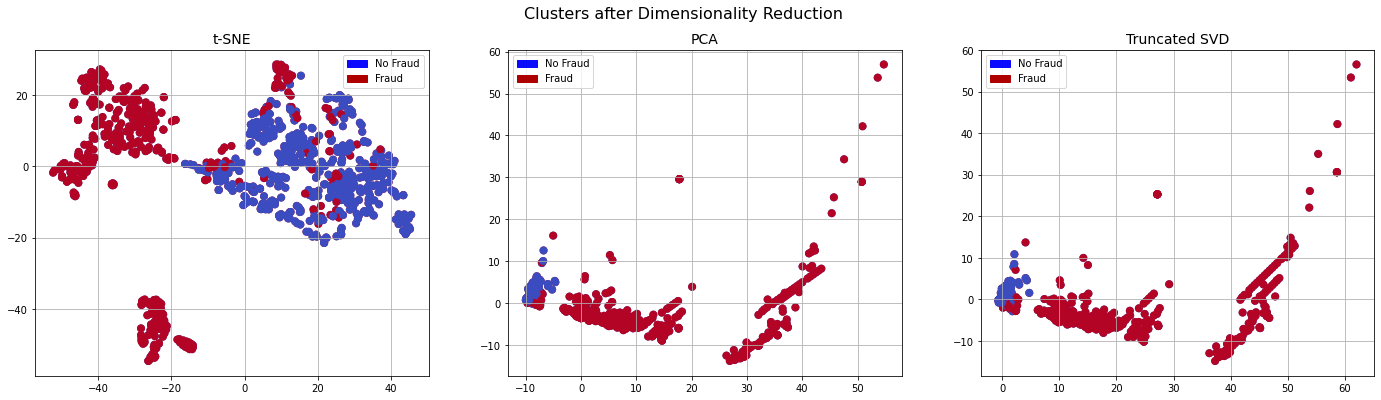

In [30]:
f, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(24, 6))
f.suptitle('Clusters after Dimensionality Reduction', fontsize=16)

labels = ['No Fraud', 'Fraud']
blue_patch = mpatches.Patch(color='#0A0AFF', label='No Fraud')
red_patch = mpatches.Patch(color='#AF0000', label='Fraud')

# t-SNE scatter plot
ax1.scatter(X_reduced_tsne[:,0], X_reduced_tsne[:,1], c=(y == 0), cmap='coolwarm', label='No Fraud', linewidths=2)
ax1.scatter(X_reduced_tsne[:,0], X_reduced_tsne[:,1], c=(y == 1), cmap='coolwarm', label='Fraud', linewidths=2)
ax1.set_title('t-SNE', fontsize=14)
ax1.grid(True)
ax1.legend(handles=[blue_patch, red_patch])

# PCA scatter plot
ax2.scatter(X_reduced_pca[:,0], X_reduced_pca[:,1], c=(y == 0), cmap='coolwarm', label='No Fraud', linewidths=2)
ax2.scatter(X_reduced_pca[:,0], X_reduced_pca[:,1], c=(y == 1), cmap='coolwarm', label='Fraud', linewidths=2)
ax2.set_title('PCA', fontsize=14)
ax2.grid(True)
ax2.legend(handles=[blue_patch, red_patch])

# TruncatedSVD scatter plot
ax3.scatter(X_reduced_svd[:,0], X_reduced_svd[:,1], c=(y == 0), cmap='coolwarm', label='No Fraud', linewidths=2)
ax3.scatter(X_reduced_svd[:,0], X_reduced_svd[:,1], c=(y == 1), cmap='coolwarm', label='Fraud', linewidths=2)
ax3.set_title('Truncated SVD', fontsize=14)
ax3.grid(True)
ax3.legend(handles=[blue_patch, red_patch])

plt.show()

### Random Undersampling으로 샘플 재구축하기

####  재구축 샘플로 분류모델 구현하기

In [34]:
# 재구축한 데이터의 클래스 분포 확인하기

new_df.groupby(by=['Class']).count()

,scaled_amount,scaled_time,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28
Class,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
0,492,492,492,492,492,492,492,492,492,492,492,492,492,492,492,492,492,492,492,492,492,492,492,492,492,492,492,492,492,492
1,492,492,492,492,492,492,492,492,492,492,492,492,492,492,492,492,492,492,492,492,492,492,492,492,492,492,492,492,492,492


In [35]:
# X와 y 데이터 셋 만들기
X = new_df.drop('Class', axis=1)
y = new_df['Class']

In [36]:
# 언더샘플링을 위한 샘플 데이터 구축
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

In [37]:
# 모델 인풋에 들어가기 위한 데이터의 형태 바꾸기
X_train = X_train.values
X_test = X_test.values
y_train = y_train.values
y_test = y_test.values

In [38]:
# 학습시킬 모델 로드하기
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from lightgbm import LGBMClassifier

classifiers = {
    "Logisitic Regression": LogisticRegression(),
    "K Nearest": KNeighborsClassifier(),
    "Support Vector Classifier": SVC(),
    "Decision Tree Classifier": DecisionTreeClassifier(),
    "Random Forest Classifier": RandomForestClassifier(),
    "Gradient Boosting Classifier": GradientBoostingClassifier(),
    "LightGBM Classifier": LGBMClassifier()
}

In [39]:
# 모델별 cross validation 한 결과의 평균 정확도 점수 출력하기
from sklearn.model_selection import cross_val_score

for key, classifier in classifiers.items():
    classifier.fit(X_train, y_train)
    training_score = cross_val_score(classifier, X_train, y_train, cv=5)
    print(classifier.__class__.__name__, ':', round(training_score.mean(), 2) * 100, '% accuracy')

LogisticRegression : 94.0 % accuracy
KNeighborsClassifier : 93.0 % accuracy
SVC : 93.0 % accuracy
DecisionTreeClassifier : 89.0 % accuracy
RandomForestClassifier : 93.0 % accuracy
GradientBoostingClassifier : 92.0 % accuracy
LGBMClassifier : 94.0 % accuracy


### 분류결과 확인하기

In [40]:
# 모델별 분류결과 확인하기 (올바른 예)
from sklearn.metrics import classification_report

for key, classifier in classifiers.items():
    y_pred = classifier.predict(original_Xtest)  ####
    results = classification_report(original_ytest, y_pred)  ####
    print(classifier.__class__.__name__, '-------','\n', results)

LogisticRegression ------- 
               precision    recall  f1-score   support

           0       1.00      0.98      0.99     56863
           1       0.07      0.89      0.13        98

    accuracy                           0.98     56961
   macro avg       0.54      0.93      0.56     56961
weighted avg       1.00      0.98      0.99     56961

KNeighborsClassifier ------- 
               precision    recall  f1-score   support

           0       1.00      0.97      0.98     56863
           1       0.05      0.92      0.09        98

    accuracy                           0.97     56961
   macro avg       0.52      0.94      0.53     56961
weighted avg       1.00      0.97      0.98     56961

SVC ------- 
               precision    recall  f1-score   support

           0       1.00      0.99      0.99     56863
           1       0.13      0.87      0.23        98

    accuracy                           0.99     56961
   macro avg       0.57      0.93      0.61     56961


In [41]:
# 모델별 Confusion Matrix 확인하기
from sklearn.metrics import confusion_matrix
for key, classifier in classifiers.items():
  y_pred = classifier.predict(X_test)
  cm = confusion_matrix(y_test, y_pred)
  print(classifier.__class__.__name__, '\n', cm, '\n')

LogisticRegression 
 [[101   0]
 [  4  92]] 

KNeighborsClassifier 
 [[101   0]
 [  7  89]] 

SVC 
 [[101   0]
 [  9  87]] 

DecisionTreeClassifier 
 [[93  8]
 [ 8 88]] 

RandomForestClassifier 
 [[100   1]
 [  6  90]] 

GradientBoostingClassifier 
 [[98  3]
 [ 6 90]] 

LGBMClassifier 
 [[101   0]
 [  6  90]] 



### SMOTE로 Oversampling 하기
### 참고:

- 리샘플링(Synthetic Minority Oversampling Technique)

- 모델 파라미터 조정
    - `scale_pos_weight`
    - `is_unbalance`
    - `{class_label: weight}`

In [ ]:
from imblearn.over_sampling import SMOTE

sm = SMOTE()
X_resampled, y_resampled = sm.fit_sample(original_Xtrain,list(original_ytrain)) ####


print('Before SMOTE, original X_train: {}'.format(original_Xtrain.shape)) 
print('Before SMOTE, original y_train: {}'.format(np.array(original_ytrain).shape))
print('After  SMOTE, resampled original X_train: {}'.format(X_resampled.shape)) 
print('After  SMOTE, resampled original y_train: {} \n'.format(np.array(y_resampled).shape))

print("Before SMOTE,     fraud counts: {}".format(sum(np.array(original_ytrain)==1)))
print("Before SMOTE, non-fraud counts: {}".format(sum(np.array(original_ytrain)==0)))
print("After  SMOTE,     fraud counts: {}".format(sum(np.array(y_resampled)==1)))
print("After  SMOTE, non-fraud counts: {}".format(sum(np.array(y_resampled)==0)))